10 emnist 0
0.42891109392567034 0.005779659722607386
0.005779659722607385 0.2311330065577851
label_based: method = label based, accs = (1.0, 0.98)


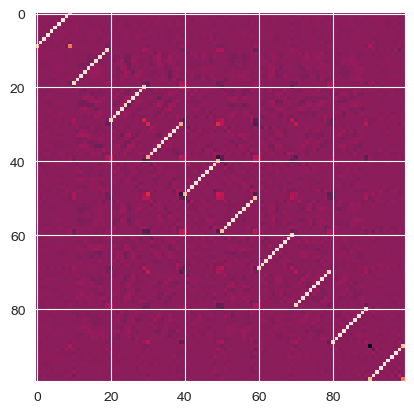

starting fine tuning epoch 1 
 Total cum loss = 0.017330862207608856
starting fine tuning epoch 21 
 Total cum loss = 0.0004451515861492381
starting fine tuning epoch 41 
 Total cum loss = 0.0005685382574382755
starting fine tuning epoch 61 
 Total cum loss = 0.001696828436345244
starting fine tuning epoch 81 
 Total cum loss = -0.0014752336662326357
starting fine tuning epoch 101 
 Total cum loss = 0.008239953701073924
starting fine tuning epoch 121 
 Total cum loss = 0.011608778544836957
starting fine tuning epoch 141 
 Total cum loss = 0.00409458920510852
starting fine tuning epoch 161 
 Total cum loss = 0.009980229140482206
starting fine tuning epoch 181 
 Total cum loss = -6.601087247522977e-05
starting fine tuning epoch 201 
 Total cum loss = -0.005318097909514466
starting fine tuning epoch 221 
 Total cum loss = 0.011324479734190764
starting fine tuning epoch 241 
 Total cum loss = 0.007607981531769356
starting fine tuning epoch 261 
 Total cum loss = 0.00458092643863434
startin

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from core import SymmetryFinder, SymmetryFinderLabel
from numpy.random import default_rng
import torchvision
import logging
import torchvision.transforms.functional as funct
import torchvision.transforms as transforms
from sklearn.utils import shuffle
import itertools
import pandas as pd
import random
import dill
from pathlib import Path

DATA_PATH = Path("..") / "data"
logging.basicConfig(filename="../logs/semisynthetic_label_based.log", level=logging.WARNING)


def ground_truth_loss(mat1, mat2):
    return np.sqrt(np.mean((mat1 - mat2) ** 2))


def horiz_flip_gt_accuracy(model, dim=(28, 28)):
    # flip = transforms.RandomHorizontalFlip(p=1.)
    # eigenvector1 = model.eigenvectors_.reshape(dim[0], dim[1], -1)

    eigenvectors = model.eigenvectors_.T.reshape(-1, dim[0], dim[1])
    diff = np.array(
        [eigenvectors[i].reshape(-1, dim[0] * dim[1]) @ eigenvectors[i, :, ::-1].reshape(-1, dim[0] * dim[1]).T for i in
         range(eigenvectors.shape[0])])
    diff = diff.reshape(-1)
    diff = np.arccos(diff) * 180 / np.pi
    diff[diff > 120] = -1
    diff[(120 >= diff) & (diff >= 60)] = 0
    diff[(0 < diff) & (diff < 60)] = 1
    return np.sum(diff == model.trans_eigenvalues_) / sum((diff != 0)), sum((diff != 0)) / len(diff)


if __name__ == '__main__':
    # num_samples = NUM_SAMPLES
    space_dims = [10]
    methods = []
    datasets = ['emnist'] # 'mnist'
    # num_samples_list = [2_000, 10_000, 50_000, 250_000]

    # print(df_error)
    df_cov_acc = pd.DataFrame(columns=space_dims, index=datasets, dtype=float)
    for dataset in datasets:
        df_acc = pd.DataFrame(columns=methods, index=space_dims, dtype=float)
        save_file = DATA_PATH / f"{dataset}_acc_lbl.csv"
        for space_dim in space_dims:
            torch.manual_seed(42)
            rng = default_rng(42)

            trans_mat = np.eye(space_dim * space_dim).reshape(space_dim, space_dim, space_dim, space_dim)
            trans_mat = trans_mat[:, :, :, ::-1]
            trans_mat = trans_mat.reshape(space_dim * space_dim, space_dim * space_dim)

            dim = (space_dim, space_dim)
            strt_msg = f"Starting Experiment: methods = {', '.join(methods)}, space_dim = {space_dim}"
            logging.info(strt_msg)
            if dataset == 'emnist':
                if space_dims == 28:
                    transform = transforms.Compose(
                        [
                            lambda x: funct.rotate(x, angle=-90),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
                else:
                    transform = transforms.Compose(
                        [
                            lambda x: funct.rotate(x, angle=-90),
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(dim),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
            else:
                if space_dims == 28:
                    transform = transforms.Compose(
                        [
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
                else:
                    transform = transforms.Compose(
                        [
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(dim),
                            transforms.ToTensor(),
                            lambda x: x.view(-1),
                            lambda x: x.numpy()])
            if dataset == 'emnist':
                trainset = torchvision.datasets.EMNIST(root=str(DATA_PATH), train=True,
                                                       download=True, transform=transform,
                                                       split="digits"
                                                       )
            else:
                trainset = torchvision.datasets.MNIST(root=str(DATA_PATH), train=True,
                                                      download=True, transform=transform,
                                                      )



            data = np.array([x for i, (x, label) in enumerate(trainset)])
            labels = np.array([label for i, (x, label) in enumerate(trainset)])
            data = data / np.std(data)
            data, labels = shuffle(data, labels)

            cov = np.cov(data, rowvar=False)
            eigen = np.linalg.eig(cov)
            cov_eigenvalues = np.real(eigen[0])
            eigenvectors = np.real(eigen[1])
            mu = np.mean(data, axis=0)
            sol = np.linalg.solve(eigenvectors, mu)
            num_trivial_vectors = np.sum((sol < SymmetryFinder.ignore_threshold) & \
                                         (cov_eigenvalues < SymmetryFinder.ignore_threshold))
            print(space_dim, dataset, num_trivial_vectors)
            swaps = int((dim[0] * dim[1] - num_trivial_vectors) // 2)
            # print(type(swaps))
            for i, method in enumerate(methods):
                sym = SymmetryFinder(fit_method=method, select_method=swaps)
                sym.fit(data, cov=cov)
                accs = horiz_flip_gt_accuracy(sym, dim=dim)
                msg = f"method = {method}, accs = {accs}"
                logging.info(msg)
                print(msg)
                df_acc.loc[space_dim, method] = accs[0]
                df_cov_acc.loc[dataset, space_dim] = accs[1]
            sym_lbl = SymmetryFinderLabel(select_method=swaps, bidirectional=True)
            sym_lbl.fit(data, labels)
            accs = horiz_flip_gt_accuracy(sym_lbl, dim=dim)
            msg = f"label_based: method = label based, accs = {accs}"
            logging.info(msg)
            print(msg)
            # print(np.linalg.norm(sym_lbl.trans_ - trans_mat), np.linalg.norm(trans_mat))
            plt.imshow(sym_lbl.trans_)
            plt.show()
            sym_lbl.fine_tune(data, lr=0.0001, bandwidth=50, epochs=1000, negativity_penalty=True)
            plt.imshow(sym_lbl.ft_trans_)
            plt.show()
            # plt.imshow(trans_mat)
            # plt.show()
            # df_acc.loc[space_dim, method] = accs[0]
            # df_cov_acc.loc[dataset, space_dim] = accs[1]
    #     df_acc.to_csv(save_file)
    # df_cov_acc.to_csv(DATA_PATH / "cov_acc_lbl.csv")

In [4]:
sym_lbl.trans_.mean(), sym_lbl.ft_trans_.mean()

(0.009879250021300716, 0.009913991)